In [3]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting

import pandas as  pd
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, image, plotting
from nilearn.datasets import load_mni152_template
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn.masking import intersect_masks
from python.acnets.parcellations.dosenbach import load_dosenbach2010_masker
from python.acnets.parcellations.gordon import \
    fetch_atlas as fetch_gordon2014_atlas
from python.acnets.parcellations import seitzman
from tqdm.auto import tqdm

tqdm.pandas()

In [4]:
# load MNI152 template
mni152_template = load_mni152_template(resolution=2)
mni152_data = mni152_template.get_fdata()[..., np.newaxis]
mni152_template = image.new_img_like(mni152_template, mni152_data)

In [5]:
from python.acnets.parcellations import difumo
difumo_masker, difumo_labels = difumo.load_masker('difumo_64_2mm', None)

difumo_labels['region_index'] = difumo_labels.reset_index().index
difumo_labels['network_index'] = difumo_labels.groupby('network').ngroup()

difumo_maps = image.load_img(difumo_masker.maps_img)

In [6]:
seitzman_masker, seitzman_labels = seitzman.load_masker('seitzman2018', None)
seitzman_labels['network_index'] = seitzman_labels.groupby('network').ngroup()

In [7]:
# dosenbach regions

_, dosenbach2010_labels = load_dosenbach2010_masker()
dosenbach2010_labels['network_index'] = dosenbach2010_labels.groupby('network').ngroup()

dosenbach2010_seeds = dosenbach2010_labels[['x','y','z']].values


In [8]:
# Gordon Network Masks

gordon2014_atlas = fetch_gordon2014_atlas()

# DEBUG
# plotting.plot_roi(gordon2014_atlas.maps, title='Gordon2014', colorbar=True)
# plt.show()

gordon_labels = gordon2014_atlas.labels.reset_index()
gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

gordon_network_names = gordon_labels.network.astype('category').cat.categories.to_list()

def get_network_index(region_index):
    net_index = 0.0
    if region_index > 0:
        net_index = gordon_labels[['network_index']].values[int(region_index)-1,0]
        net_index = net_index.astype('float')

    return net_index

gordon_network_maps = image.load_img(gordon2014_atlas.maps).get_fdata()
gordon_network_maps = np.vectorize(get_network_index)(gordon_network_maps)
gordon_network_maps = image.new_img_like(gordon2014_atlas.maps, gordon_network_maps)
gordon_network_maps = image.resample_to_img(gordon_network_maps, mni152_template)

In [53]:
def compute_network_mask(regions, atlas,
                         mni152=None,
                         gordon_network_maps=gordon_network_maps):

    if 'gordon2014' in atlas.lower():
        network_idx = regions['network_index'].unique()[0]
        _mask_img =  image.math_img(f'np.where(img == {network_idx}, 1.0, 0.0)',
                                    img=gordon_network_maps)
        # _mask = np.where(gordon_network_maps.get_fdata() == network_idx, 1.0, 0.0)
        # _mask_img = image.new_img_like(mni152_template, _mask)
        _mask_img = image.index_img(_mask_img, 0)

    elif 'dosenbach2010' in atlas.lower():
        seeds = regions[['x','y','z']].values
        _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)
        _mask = A.toarray().sum(axis=0).reshape(mni152.shape)
        _mask_img = image.new_img_like(mni152, _mask)

    elif 'seitzman2018' in atlas.lower():
        seeds = regions[['x','y','z']].values
        _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=True)
        _mask = A.toarray().sum(axis=0).reshape(mni152.shape)
        _mask_img = image.new_img_like(mni152, _mask)

    # elif 'difumo' in atlas.lower():
    #     region_idxs = regions['region_index'].to_list()
    #     _imgs = image.index_img(difumo_maps, region_idxs)
    #     _imgs = image.binarize_img(_imgs)
    #     _imgs = list(image.iter_img(_imgs))
    #     _mask_img = intersect_masks(_imgs, threshold=0, connected=False)

    return _mask_img

gordon_network_masks = gordon_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='gordon2014', mni152=mni152_template).to_frame()
gordon_network_masks['atlas'] = 'gordon2014'

dosenbach_network_masks = dosenbach2010_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='dosenbach2010', mni152=mni152_template).to_frame()
dosenbach_network_masks['atlas'] = 'dosenbach2010'

seitzman_network_masks = seitzman_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='seitzman2018', mni152=mni152_template).to_frame()
seitzman_network_masks['atlas'] = 'seitzman2018'

# combine and cleanup
network_masks = pd.concat([gordon_network_masks,
                           dosenbach_network_masks,
                           seitzman_network_masks], axis=0)
network_masks = network_masks.reset_index()
network_masks.columns = ['network', 'mask', 'atlas']

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [54]:
# cleanups


network_masks['network'] = network_masks['network'].replace({
    'None': 'unassigned',
    # 'cingulo-opercular': 'cingulo-opercular',
    }, regex=False)


network_masks['network_index'] = network_masks.groupby('atlas')['network'].transform(
    lambda x: np.arange(x.nunique()) + 1)

network_masks

,network,mask,atlas,network_index
0,Auditory,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,1
1,CinguloOperc,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,2
2,CinguloParietal,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,3
3,Default,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,4
4,DorsalAttn,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,5
5,FrontoParietal,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,6
6,unassigned,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,7
7,RetrosplenialTemporal,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,8
8,SMhand,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,9
9,SMmouth,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,gordon2014,10


In [55]:
# plot gordon-dosenbach intersections
%%script echo skipping...

gordon_network_masks = network_masks.query('atlas == "gordon2014"')
dosenbach_network_masks = network_masks.query('atlas == "dosenbach2010"')

for gnet_name, gnet_mask in tqdm(gordon_network_masks.iteritems(), total=13):
    print(f'{gnet_name}:')
    for dnet_name, dnet_mask in dosenbach_network_masks.iteritems():
        overlap_mask = intersect_masks([gnet_mask, dnet_mask], connected=False)
        overlap_size = image.get_data(overlap_mask).sum()
        if overlap_size >= 40:
            print(f'\t{dnet_name}\t{overlap_size}')
            display = plotting.plot_glass_brain(
                gnet_mask,
                cmap='winter',
                zorder=0,
                title=f'Gordon_{gnet_name} — Dosenbach_{dnet_name}',
                colorbar=False)
            display.add_overlay(dnet_mask, cmap='summer', zorder=1)
            display.add_overlay(overlap_mask, cmap='autumn', zorder=10)
            plt.show()

UsageError: Line magic function `%%script` not found.


  0%|          | 0/14 [00:00<?, ?it/s]

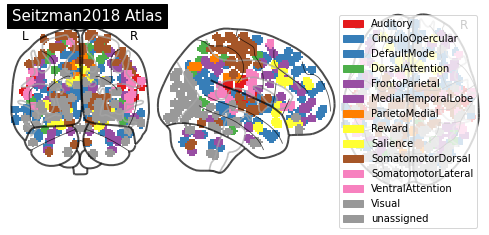

In [69]:
# %%script false --no-raise-error

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches


cmap = matplotlib.cm.get_cmap('Set1')

def plot_network(network, display=None):
    # if 'unassigned' in network.network:
    #     return 

    network_color = cmap(network.network_index / 14.0)

    network_cmap = LinearSegmentedColormap.from_list('net_cmap', [network_color, network_color])

    display.add_overlay(network['mask'], cmap=network_cmap)

    return network.network, network_color


seitzman_display = plotting.plot_glass_brain(None, title=f'Seitzman2018 Atlas', colorbar=False)

network_colors = network_masks.query('atlas == "seitzman2018"').progress_apply(
    plot_network,
    display=seitzman_display,
    axis=1)

legend_patches =  []
for label, color in network_colors:
    patch = mpatches.Patch(color=color, label=label)
    legend_patches.append(patch)
    
plt.legend(handles=legend_patches)


plt.show()


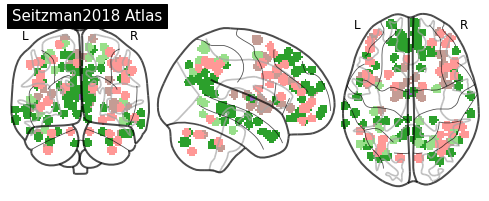

In [125]:
# WIP & TESTING

# image.
_network_masks = network_masks.query('atlas == "seitzman2018"').reset_index(drop=True)
_network_masks['network_index'] =  _network_masks.index + 1

def prep_mask(network):
    _network_idx = network['network_index']
    _mask = image.math_img(f'img * {_network_idx}', img=network['mask'])
    return _mask

# _network_masks.apply(prep_mask, axis=1)
_combined_mask = image.concat_imgs(_network_masks.apply(prep_mask, axis=1).to_list())

display = plotting.plot_glass_brain(
    image.index_img(_combined_mask, 1),
    title='Seitzman2018 Atlas',
    cmap='tab20',
    vmax=14, vmin=0,
    colorbar=False)

display.add_overlay(
    image.index_img(_combined_mask, 2),
    cmap='tab20',
    vmax=14, vmin=0,
    )

display.add_overlay(
    image.index_img(_combined_mask, 3),
    cmap='tab20',
    vmax=14, vmin=0,
    )

display.add_overlay(
    image.index_img(_combined_mask, 4),
    cmap='tab20',
    vmax=14, vmin=0,
    )

plt.show()